# Installation of Pytorch

In [22]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

# RealNVP Network

In [0]:
import torch
from torch.autograd import Variable
import numpy as np

class RealNVP(torch.nn.Module):
    """

    Args:
        Nvars (int): number variables.
        Nlayers (int): number of layers.
        Hs (int): number of hidden neurons of the s neural network.
        Ht (int): number of hidden neurons of the t neural network.

    """
    def __init__(self, Nvars, Nlayers=2,Hs=10, Ht=10):
        super(RealNVP, self).__init__()
        self.Nvars = Nvars
        self.Nhalf = int(Nvars/2)
        self.Nlayers = Nlayers
        self.Hs = Hs
        self.Ht = Ht

        self.name ='realnvp'
        self.s = torch.nn.ModuleList()
        self.t = torch.nn.ModuleList()
        for i in range(self.Nlayers):
            if i != self.Nlayers-1:
                self.s.append (
                     torch.nn.Sequential(
                     torch.nn.Linear(self.Nhalf, Hs),
                     torch.nn.ReLU(),
                     torch.nn.Linear(Hs, self.Nhalf)
                     ))
            self.t.append(
                 torch.nn.Sequential(
                 torch.nn.Linear(self.Nhalf, Ht),
                 torch.nn.ReLU(),
                 torch.nn.Linear(Ht, self.Nhalf)
                 ))
            self.s.append(
                torch.nn.Sequential(
                torch.nn.Linear(self.Nhalf, Hs),
                torch.nn.ReLU(),
                torch.nn.Linear(Hs, self.Nhalf),
                torch.nn.Tanh()
                ))

    def forward(self, x):
        y0 = x[:,0:self.Nhalf]
        y1 = x[:,self.Nhalf:self.Nvars]
        self.logjac = Variable(torch.zeros(x.data.shape[0]))
        for i in range(self.Nlayers):
            if (i%2==0):
                y1 = y1 * torch.exp(self.s[i](y0))  + self.t[i](y0)
                self.logjac += self.s[i](y0).sum(dim=1)
            else:
                y0 = y0 * torch.exp(self.s[i](y1)) +  self.t[i](y1)
                self.logjac += self.s[i](y1).sum(dim=1)
        return torch.cat((y0, y1), 1)

    def backward(self, z):
        y0 = z[:,0:self.Nhalf]
        y1 = z[:,self.Nhalf:self.Nvars]
        self.logjac = Variable(torch.zeros(z.data.shape[0]))
        for i in list(range(self.Nlayers))[::-1]:
            if (i%2==1):
                y0 = (y0 - self.t[i](y1)) * torch.exp(-self.s[i](y1))
                self.logjac -= self.s[i](y1).sum(dim=1)
            else:
                y1 = (y1 - self.t[i](y0)) * torch.exp(-self.s[i](y0))
                self.logjac -= self.s[i](y0).sum(dim=1)
        return torch.cat((y0, y1), 1)

    def logp(self, x):
        z = self.backward(x)
        return -0.5*(z**2).sum(dim=1) + self.logjac

## Reversibility Check

(New line of test added to check if $Log(Jacobian)$ is equal between generate and inference process.)

In [0]:
Nvars = 4
model = RealNVP(Nvars)
testX = Variable(torch.randn(1000,Nvars))
forward = model.forward(testX)
forwardLogjac = model.logjac
backward = model.backward(forward)
backwardLogjac = model.logjac
from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(backward.data.numpy(),testX.data.numpy())
assert_array_almost_equal(forwardLogjac.data.numpy(),-backwardLogjac.data.numpy())

##Training Network

--2018-02-06 02:22:12--  https://pastebin.com/raw/JWgv53pd
Resolving pastebin.com (pastebin.com)... 104.20.208.21, 104.20.209.21
Connecting to pastebin.com (pastebin.com)|104.20.208.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘train.dat’

train.dat               [ <=>                ] 180.85K  --.-KB/s    in 0.04s   

2018-02-06 02:22:12 (4.67 MB/s) - ‘train.dat’ saved [185188]



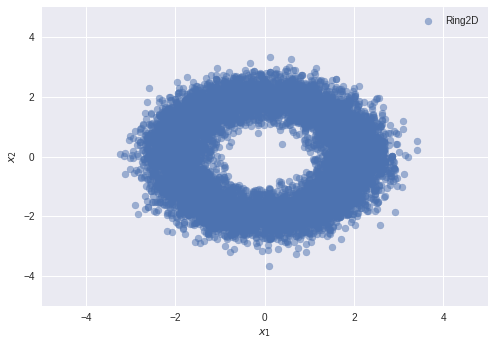

In [25]:
import matplotlib.pyplot as plt
!wget https://pastebin.com/raw/JWgv53pd -O train.dat
xy = np.loadtxt('./train.dat', dtype=np.float32)
x_data = Variable(torch.from_numpy(xy[:, :]))
Nvars = x_data.data.shape[-1]
plt.figure()
plt.scatter(x_data[:,0], x_data[:,1], alpha=0.5, label='Ring2D')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

In [0]:
Nepochs = 800
Nlayers = 4
Hs = 10
Ht = 10
model = RealNVP(Nvars, Nlayers,Hs,Ht)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

epoch: 0 loss: 2.7654638290405273
epoch: 50 loss: 1.6150529384613037
epoch: 100 loss: 1.4390106201171875
epoch: 150 loss: 1.3559811115264893
epoch: 200 loss: 1.3278197050094604
epoch: 250 loss: 1.3035414218902588
epoch: 300 loss: 1.2878526449203491
epoch: 350 loss: 1.2691082954406738
epoch: 400 loss: 1.2573339939117432
epoch: 450 loss: 1.246930718421936
epoch: 500 loss: 1.2447091341018677
epoch: 550 loss: 1.2469640970230103
epoch: 600 loss: 1.2376819849014282
epoch: 650 loss: 1.2379766702651978
epoch: 700 loss: 1.236959457397461
epoch: 750 loss: 1.2366176843643188


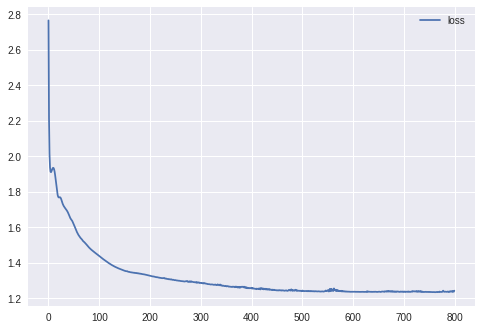

In [27]:
L = []
f = plt.figure()
ax = f.add_subplot(1,1,1)
for epoch in range(Nepochs):
    logp = model.logp(x_data)
    loss = -logp.mean()
    if epoch%50 == 0:
      print("epoch:",epoch,"loss:",loss.data[0])
    L.append(loss.data.numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
ax.plot(range(len(L)),np.array(L),label = 'loss')
ax.legend()
plt.show()

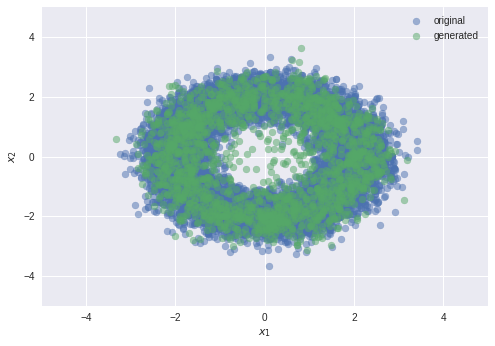

In [28]:
import matplotlib.pyplot as plt
Nsamples = 2000
z = Variable(torch.randn(Nsamples, Nvars), volatile=True)
x = model.forward(z)
plt.figure()
plt.scatter(x_data[:,0], x_data[:,1], alpha=0.5, label='original')
plt.scatter(x[:,0], x[:,1], alpha=0.5, label='generated')
plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()